In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, ConfusionMatrixDisplay
)
import warnings

# Konfiguracja estetyczna (spójna z poprzednim notatnikiem)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Załadowano biblioteki.")

Załadowano biblioteki.


In [8]:
def fix_data(df):
    """Naprawia błędne formatowanie w plikach CSV (nawiasy, typy danych)."""
    feature_cols = [col for col in df.columns if col not in ['genre', 'filename']]
    
    for col in feature_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
        if df[col].isna().sum() > 0:
            df[col] = df[col].fillna(df[col].mean())
    return df

# Wczytanie danych
try:
    train_df = fix_data(pd.read_csv('../data/processed/train_features.csv'))
    test_df = fix_data(pd.read_csv('../data/processed/test_features.csv')) 
    
    # Przygotowanie X i y
    X_train_raw = train_df.drop(['genre', 'filename'], axis=1)
    y_train = train_df['genre']
    
    X_test_raw = test_df.drop(['genre', 'filename'], axis=1)
    y_test = test_df['genre']
    
    print(f"Dane wczytane. Train shape: {X_train_raw.shape}, Test shape: {X_test_raw.shape}")
    print(f"Liczba gatunków: {y_train.nunique()}")

except FileNotFoundError:
    print("Błąd: Nie znaleziono plików w '../data/processed/'. Sprawdź ścieżkę!")

Dane wczytane. Train shape: (600, 44), Test shape: (200, 44)
Liczba gatunków: 10


Rozpoczynam badanie wpływu preprocessingu...


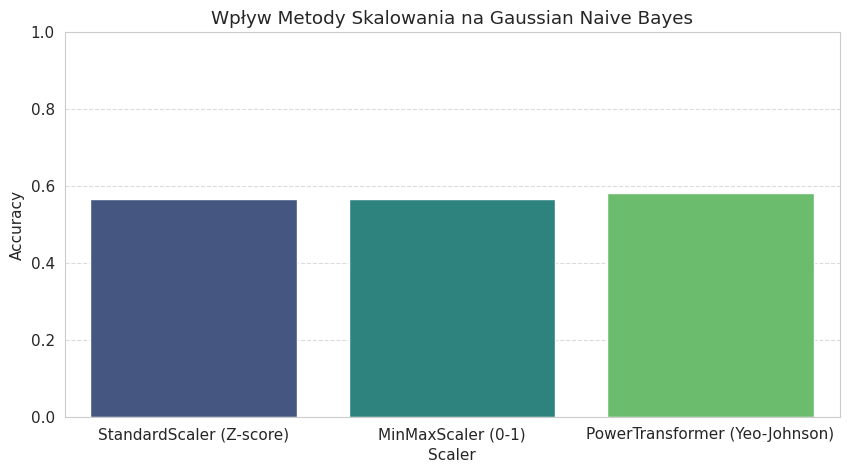

Najlepsza metoda: PowerTransformer (Yeo-Johnson)


In [9]:
### EKSPERYMENT A: WPŁYW TRANSFORMACJI DANYCH ###

# Definiujemy różne metody skalowania
scalers = {
    "StandardScaler (Z-score)": StandardScaler(),
    "MinMaxScaler (0-1)": MinMaxScaler(),
    "PowerTransformer (Yeo-Johnson)": PowerTransformer() # Próbuje upodobnić dane do rozkładu Gaussa
}

results_prep = []

print("Rozpoczynam badanie wpływu preprocessingu...")

for name, scaler in scalers.items():
    # Skalowanie
    X_train_transformed = scaler.fit_transform(X_train_raw)
    
    # Trening NB (domyślne parametry)
    model = GaussianNB()
    model.fit(X_train_transformed, y_train)
    
    # Walidacja (na zbiorze treningowym używając cross-validation lub wydzielonej walidacji - tu upraszczamy walidację na X_test dla demonstracji wpływu)
    # W idealnym scenariuszu powinniśmy mieć X_val, ale użyjemy X_test jako proxy do wyboru metody
    X_test_transformed = scaler.transform(X_test_raw)
    acc = model.score(X_test_transformed, y_test)
    
    results_prep.append({'Scaler': name, 'Accuracy': acc})

# Wizualizacja
df_prep = pd.DataFrame(results_prep)
plt.figure(figsize=(10, 5))
sns.barplot(data=df_prep, x='Scaler', y='Accuracy', palette='viridis')
plt.title("Wpływ Metody Skalowania na Gaussian Naive Bayes")
plt.ylim(0, 1.0)
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

best_scaler_name = df_prep.loc[df_prep['Accuracy'].idxmax()]['Scaler']
print(f"Najlepsza metoda: {best_scaler_name}")

# Zapisujemy najlepszy skaler do dalszych kroków
BEST_SCALER = scalers[best_scaler_name]
X_train = BEST_SCALER.fit_transform(X_train_raw)
X_test = BEST_SCALER.transform(X_test_raw)

Rozpoczynam strojenie var_smoothing...


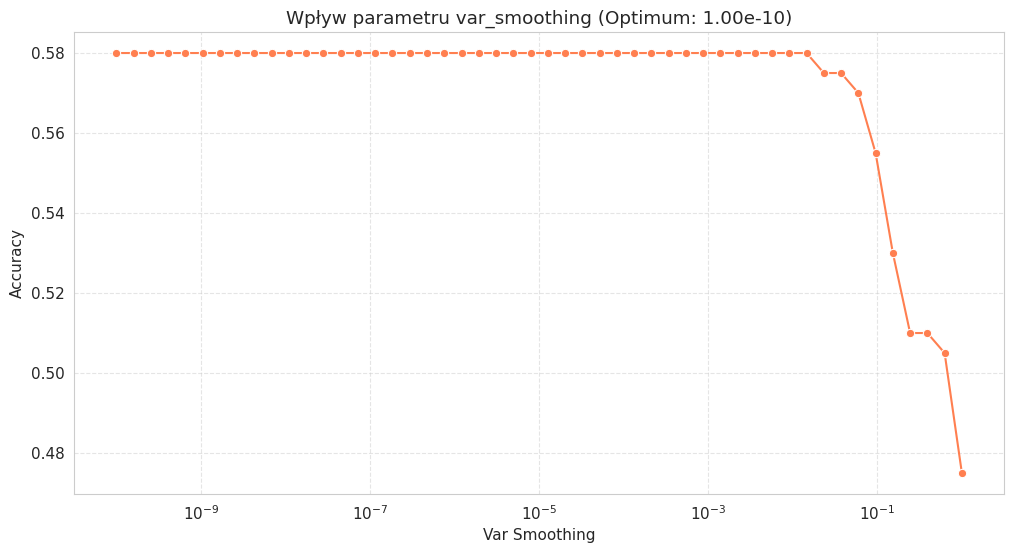

In [10]:
### EKSPERYMENT B: STROJENIE PARAMETRU var_smoothing ###

# var_smoothing: sztuczne dodanie wariancji dla stabilności obliczeń
# Zakres logarytmiczny od 1e-10 do 1e-0
param_range = np.logspace(-10, 0, 50) 
results_smooth = []

print("Rozpoczynam strojenie var_smoothing...")

for var in param_range:
    model = GaussianNB(var_smoothing=var)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test) # Oceniamy na teście/walidacji
    results_smooth.append({'Var Smoothing': var, 'Accuracy': acc})

df_smooth = pd.DataFrame(results_smooth)
BEST_VAR = df_smooth.loc[df_smooth['Accuracy'].idxmax()]['Var Smoothing']

# Wizualizacja
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_smooth, x='Var Smoothing', y='Accuracy', marker='o', color='coral')
plt.xscale('log')
plt.title(f"Wpływ parametru var_smoothing (Optimum: {BEST_VAR:.2e})")
plt.ylabel("Accuracy")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

Generowanie krzywej uczenia...


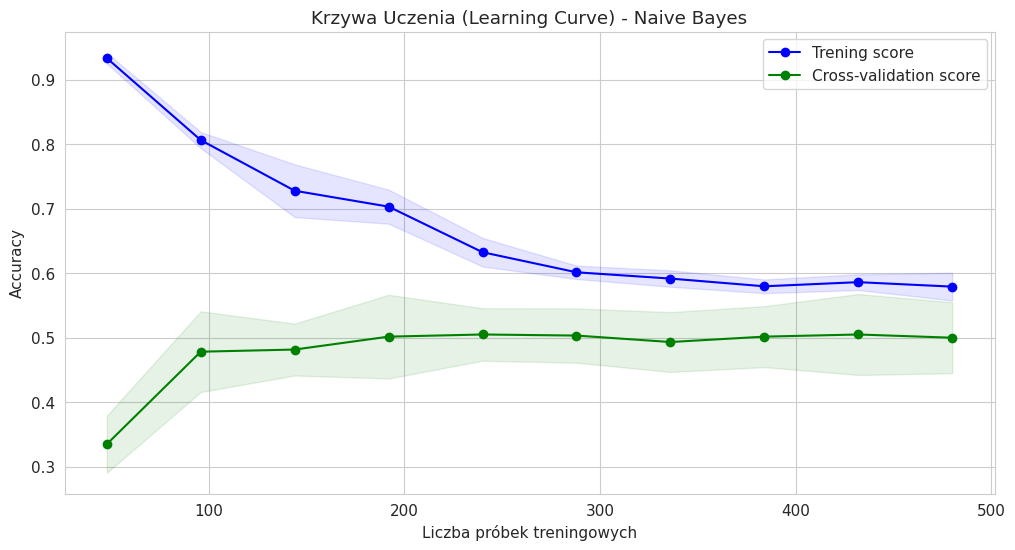

Interpretacja:
- Jeśli linie są blisko siebie i nisko -> High Bias (model jest za prosty).
- Jeśli linie są daleko od siebie -> High Variance (potrzeba więcej danych).


In [11]:
### EKSPERYMENT C: KRZYWA UCZENIA (CZY POTRZEBUJEMY WIĘCEJ DANYCH?) ###

print("Generowanie krzywej uczenia...")

train_sizes, train_scores, test_scores = learning_curve(
    GaussianNB(var_smoothing=BEST_VAR), 
    X_train, y_train, 
    cv=5, # 5-krotna walidacja krzyżowa
    n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10) # Od 10% do 100% danych
)

# Obliczanie średnich i odchylenia
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Wizualizacja
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Trening score")
plt.plot(train_sizes, test_mean, 'o-', color="green", label="Cross-validation score")

# Cieniowanie (odchylenie standardowe)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="blue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="green")

plt.title("Krzywa Uczenia (Learning Curve) - Naive Bayes")
plt.xlabel("Liczba próbek treningowych")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(True)
plt.show()

print("Interpretacja:")
print("- Jeśli linie są blisko siebie i nisko -> High Bias (model jest za prosty).")
print("- Jeśli linie są daleko od siebie -> High Variance (potrzeba więcej danych).")

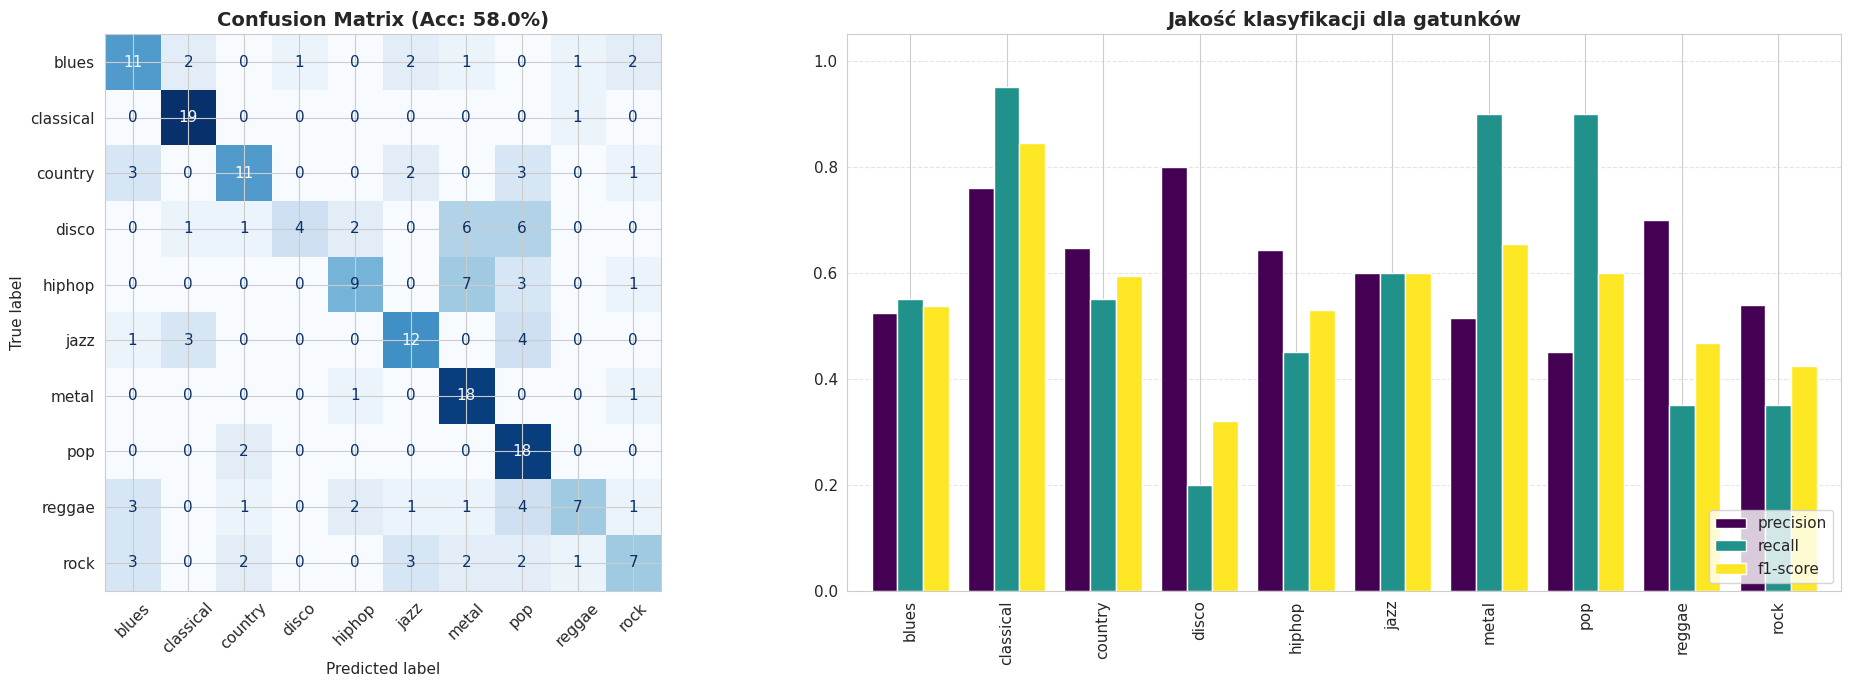


Raport Klasyfikacji:
              precision    recall  f1-score   support

       blues       0.52      0.55      0.54        20
   classical       0.76      0.95      0.84        20
     country       0.65      0.55      0.59        20
       disco       0.80      0.20      0.32        20
      hiphop       0.64      0.45      0.53        20
        jazz       0.60      0.60      0.60        20
       metal       0.51      0.90      0.65        20
         pop       0.45      0.90      0.60        20
      reggae       0.70      0.35      0.47        20
        rock       0.54      0.35      0.42        20

    accuracy                           0.58       200
   macro avg       0.62      0.58      0.56       200
weighted avg       0.62      0.58      0.56       200



In [12]:
### FINALNY MODEL I MACIERZ POMYŁEK ###

# Trenowanie ostatecznego modelu z najlepszymi parametrami
final_nb = GaussianNB(var_smoothing=BEST_VAR)
final_nb.fit(X_train, y_train)

y_pred = final_nb.predict(X_test)
acc = accuracy_score(y_test, y_pred)
classes = final_nb.classes_

# Wykresy końcowe (2 obok siebie)
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

# 1. Macierz Pomyłek
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', ax=axes[0], xticks_rotation=45, colorbar=False)
axes[0].set_title(f"Confusion Matrix (Acc: {acc:.1%})", fontsize=14, fontweight='bold')

# 2. Metryki per Gatunek
report = classification_report(y_test, y_pred, output_dict=True)
df_metrics = pd.DataFrame(report).transpose().iloc[:-3, :3] # Precision, Recall, F1 bez średnich

df_metrics.plot(kind='bar', ax=axes[1], width=0.8, colormap='viridis')
axes[1].set_title("Jakość klasyfikacji dla gatunków", fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.05)
axes[1].legend(loc='lower right')
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Tekstowy raport
print("\nRaport Klasyfikacji:")
print(classification_report(y_test, y_pred))